In [1]:
using PyPlot, FileIO, AnomalyDetection, EvalCurves, Flux, Statistics
import PyPlot: plot
include("./plots.jl")

┌ Info: Precompiling AnomalyDetection [2069a70b-aa58-5cc0-a11c-32e347b774c5]
└ @ Base loading.jl:1187
┌ Info: Precompiling FluxExtensions [76425322-8995-11e8-0106-93ec95767fb2]
└ @ Base loading.jl:1187


loaded


PyPlot.plot

In [2]:
# load data
dataset = load("toy_data_3.jld2")["data"]
#dataset = load("moon.jld")["data"]
X = AnomalyDetection.Float.(dataset.data)
Y = dataset.labels
nX = X[:, Y.==0]

2×90 Array{Float32,2}:
 0.803442  0.804605  0.807145  0.819485  …  0.0350314  0.0613807  0.0685027
 0.821998  0.834235  0.826129  0.848182     0.973926   1.00745    0.973256 

In [3]:
# model settings
indim = size(X,1)
hiddendim = 10
latentdim = 2
nlayers = 2
contamination = size(Y[Y.==1],1)/size(Y, 1) # for automatic threshold computation
iterations = 2000
lambda = 1e-3
esize = [indim; hiddendim; hiddendim; latentdim*2] # encoder architecture
#esize = [latentdim; hiddendim; hiddendim; indim]
# decoder architecture
dsize = [latentdim; hiddendim; hiddendim; indim]
#dsize = [indim; hiddendim; hiddendim; 1]
batchsize = 30

# setup the ensemble object
constructor = VAEmodel
nmodels = 20
af = mean # aggregation function for the ensemble
model = Ensemble(constructor, nmodels, af, esize, dsize; contamination = contamination,
    iterations = iterations, verbfit = false, batchsize = batchsize);

In [4]:
# fit the model
@time AnomalyDetection.fit!(model, nX)
AnomalyDetection.setthreshold!(model, X)

 50.756470 seconds (159.71 M allocations: 7.460 GiB, 4.37% gc time)


0.0039682593f0

In [5]:
# predict labels on testing data
global tryhat = AnomalyDetection.predict(model, X)

103-element Array{Int64,1}:
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 ⋮
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1

In [6]:
# get the labels and roc stats
tryhat, tstyhat = AnomalyDetection.rocstats(dataset, dataset, model);


 Training data performance: 
MLBase.ROCNums{Int64}
  p = 13
  n = 90
  tp = 13
  tn = 89
  fp = 1
  fn = 0
precision: 0.9285714285714286
f1score: 0.9629629629629629
recall: 1.0
false positive rate: 0.011111111111111112
equal error rate: 0.005555555555555556

 Testing data performance: 
MLBase.ROCNums{Int64}
  p = 13
  n = 90
  tp = 13
  tn = 88
  fp = 2
  fn = 0
precision: 0.8666666666666667
f1score: 0.9285714285714286
recall: 1.0
false positive rate: 0.022222222222222223
equal error rate: 0.011111111111111112


In [7]:
# anomaly score contour plot
# get limits of the figure
xl = (minimum(X[1,:])-0.05, maximum(X[1,:]) + 0.05)
yl = (minimum(X[2,:])-0.05, maximum(X[2,:]) + 0.05)

# compute the anomaly score on a grid
x = range(xl[1], stop=xl[2], length=30)
y = range(yl[1], stop=yl[2], length=30)
zz = zeros(size(y,1),size(x,1))
for i in 1:size(y, 1)
    for j in 1:size(x, 1)
        zz[i,j] = AnomalyDetection.anomalyscore(model, AnomalyDetection.Float.([x[j], y[i]]))
    end
end

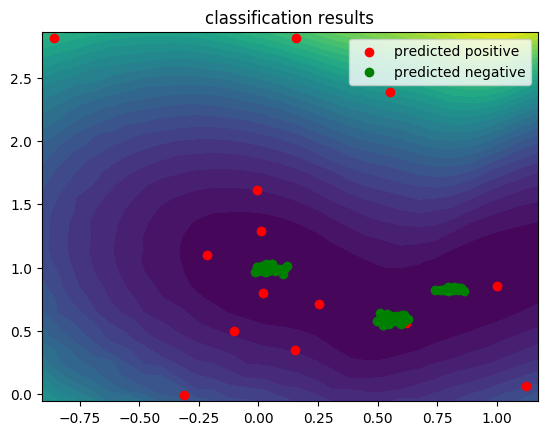

In [8]:
# plot it all
f = figure()
contourf(x, y, zz,30)
scatter(X[1, tryhat.==1], X[2, tryhat.==1], c = "r", 
    label = "predicted positive")
scatter(X[1, tryhat.==0], X[2, tryhat.==0], c = "g", 
    label = "predicted negative")
title("classification results")
xlim(xl)
ylim(yl)
legend()
show()

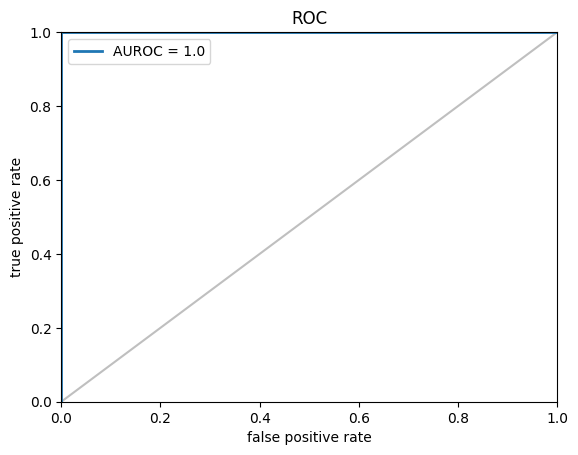

In [9]:
# plot ROC curve and compute AUROC score
ascore = AnomalyDetection.anomalyscore(model, X);
fprvec, tprvec = EvalCurves.roccurve(ascore, Y)
auroc = round(EvalCurves.auc(fprvec, tprvec),digits=3)
EvalCurves.plotroc((fprvec, tprvec, "AUROC = $(auroc)"))
show()